In [15]:
!pip install numpy matplotlib cvxopt pandas yfinance finquant plotly cufflinks chart_studio pandas_datareader

In [16]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cvxopt as opt
from cvxopt import blas, solvers
import pandas as pd
import yfinance as yf
import random
from scipy.optimize import minimize
from finquant.portfolio import build_portfolio

np.random.seed(123)

# Turn off progress printing 
solvers.options['show_progress'] = False
# (*) To communicate with Plotly's server, sign in with credentials file
import plotly as py  

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *

import cufflinks

In [17]:
def rand_weights(n):
    ''' Produces n random weights that sum to 1 '''
    k = np.random.rand(n)
    return k / sum(k)

def random_portfolio(TREASURY_BILL_RATE, returns, mutate = False, weights = None):
    ''' 
    Returns the mean and standard deviation of returns for a random portfolio
    '''
    if mutate is True and weights is not None:
        w = weights
        position = random.sample(range(0,len(w)),1)
        np.put(w, position, np.random.rand(1))
        w = w / sum(w)
        w = w.astype(float)
    elif weights is not None:
        w = weights
    else:
        w = rand_weights(len(pd.DataFrame(returns).columns))
        
    p = np.asmatrix(np.mean(returns, axis=0))
    
    C = np.array(pd.DataFrame(returns).cov().values)
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    #print([mu,sigma])
    #returns = np.dot(weights, returns_annual)
    #volatility = np.sqrt(np.dot(weights.T, np.dot(cov_annual, weights)))
    #sharpe = (returns - TREASURY_BILL_RATE) / volatility
    #sharpe_ratio.append(sharpe)
    
    sharpe = (mu-TREASURY_BILL_RATE)/sigma
    
    # This recursion reduces outliers to keep plots pretty
    #if sigma > 2:
        #return random_portfolio(returns, w = None)
    return np.float(mu), np.float(sigma), np.float(sharpe), np.array(w,dtype=object)

'''
#derive efficient frontier
def optimal_portfolio(returns):
    n = len(returns)
    # Convert to cvxopt matrices
    S = opt.matrix(np.array(pd.DataFrame(returns).cov().values))
    
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    #S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=0))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    #weights = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[len(m1)-1] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    #sr = np.array(returns)/np.array(risks)
    return returns, risks
'''

def optimal_portfolio(returns):
    n = len(returns)
    returns = np.asmatrix(returns)
    
    N = 100
    mus = [10**(5.0 * t/N - 1.0) for t in range(N)]
    
    # Convert to cvxopt matrices
    S = opt.matrix(np.cov(returns))
    pbar = opt.matrix(np.mean(returns, axis=1))
    
    # Create constraint matrices
    G = -opt.matrix(np.eye(n))   # negative n x n identity matrix
    h = opt.matrix(0.0, (n ,1))
    A = opt.matrix(1.0, (1, n))
    b = opt.matrix(1.0)
    
    # Calculate efficient frontier weights using quadratic programming
    portfolios = [solvers.qp(mu*S, -pbar, G, h, A, b)['x'] 
                  for mu in mus]
    ## CALCULATE RISKS AND RETURNS FOR FRONTIER
    returns = [blas.dot(pbar, x) for x in portfolios]
    risks = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    #weights = [np.sqrt(blas.dot(x, S*x)) for x in portfolios]
    
    ## CALCULATE THE 2ND DEGREE POLYNOMIAL OF THE FRONTIER CURVE
    m1 = np.polyfit(returns, risks, 2)
    x1 = np.sqrt(m1[len(m1)-1] / m1[0])
    # CALCULATE THE OPTIMAL PORTFOLIO
    #wt = solvers.qp(opt.matrix(x1 * S), -pbar, G, h, A, b)['x']
    #sr = np.array(returns)/np.array(risks)
    return returns, risks

def optimize_sharpe_ratio(returns, TREASURY_BILL_RATE = None):
    
    r1=returns
    #((((np.exp(returns))-1)*252.75)+1- TREASURY_BILL_RATE)/100
    r = r1 *-1
    
    def sharpe_portfolio(w):
        ''' 
        Returns the mean and standard deviation of returns for a random portfolio
        '''        
        p = np.asmatrix(np.mean(r, axis=0))

        C = np.asmatrix(np.array(pd.DataFrame(r1).cov().values))

        mu = np.asmatrix(w) * p.T
        sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)

        sharpe = mu/sigma

        # This recursion reduces outliers to keep plots pretty
        #if sigma > 2:
            #return random_portfolio(returns, w = None)
        return np.float(sharpe)

    res = minimize(sharpe_portfolio, rand_weights(len(r)).reshape(-1, 1),
      constraints=[
        {'type': 'eq', 'fun': lambda w: np.sum(w) - 1.},
      ],
      bounds=[(0., 1.) for i in range(len(r))])

    return(random_portfolio(r1, False, res.x))

def _variance(covariance_matrix, w):
    return (w.reshape(-1, 1).T @ covariance_matrix @ w.reshape(-1, 1))[0][0]

def get_ret_vol_sr(weights,returns):
    
    p = np.asmatrix(np.mean(returns, axis=0))
    w = weights
    C = np.asmatrix(np.array(pd.DataFrame(returns).cov().values))
    
    mu = np.asmatrix(w) * p.T
    sigma = np.sqrt(np.asmatrix(w) * C * np.asmatrix(w).T)
    
    sharpe = mu/sigma
    
    return np.array([mu, sigma, sharpe])

def dl(stock, start, end):
    subset = yf.download(stock, start=start, end=end, auto_adjust=True).iloc[:, :6].dropna(axis=0, how='any')
    subset = subset[start:end]
    subset2 = subset[start:end]
    if (len(subset) != 0) and (len(subset2)!=0):
        return (subset)

def unique(list1):
 
    # intilize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)

    return(unique_list)    

In [18]:
import pandas as pd
end = pd.Timestamp.utcnow()
start = (end - 2500 * pd.tseries.offsets.BDay())
start = start.strftime('%Y-%m-%d')
end = end.strftime('%Y-%m-%d')


In [19]:
import pandas as pd
import random

# There are 2 tables on the Wikipedia page
# we want the first table

payload=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
first_table = payload[0]
second_table = payload[1]

sp500 = first_table
symbols_sp500 = sp500['Symbol'].values.tolist()

payload=pd.read_html('https://en.wikipedia.org/wiki/Nasdaq-100#Components')
table = payload[3]

ns100 = table
symbols_ns100 = ns100['Ticker'].values.tolist()

payload=pd.read_html('https://en.wikipedia.org/wiki/S%26P_500_Dividend_Aristocrats#Index')
dividendAristocraft = list(payload[2]['Ticker symbol'])

payload=pd.read_html('https://finance.yahoo.com/quote/SPY/holdings/')
#dividendAristocraft = payload[2]['Ticker symbol']

top10 = list(payload[0]['Symbol'])



In [20]:
'''

etf_commodities = ['DBO','CORN', 'WEAT', 'SOYB', 'JO', 'SGG', 'BAL', 'COW', 'MOO', 'TAGS', 'KOL' ]
#Gold, Silver, Platinum, Copper, Paladium, Aluminum, Iron, Steel
etf_metals = ['IAU', 'SLV', 'PGM', 'JJC', 'PALL', 'JJU', 'IFUNX', 'SLX']
#US dollar, European Euro, Japanese yen, Pound sterling, Australian dollar, Canadian dollar, Swiss franc, Chinese Yuan Renminbi, Swedish Krona, Peso, India
#defunct: Russia: XRU, Mexico: FXM
#etf_foreign_exchanges = ['UUP','FXE','FXY','FXB','FXA','FXC','FXF','CYB', 'FXS', 'INR']
#residential, Ishares all NAmerica
etf_real_estate = ['REZ', 'IYR']
#Russia, Germany, UK, Japan, China, Euro, Euro, Brazil, Latin America, Mexico, India
#etf_economies = ['ERUS','EWG','EWU','EWJ','MCHI','EZU','IEUR','EWZ','ILF','EWW','INDA']
#Ishares Investment Grade, IShares core aggregate Investment grade, Short, Total, 1-5 Years, 5-10 Years, 10 Years, Gov/Credit
#defunct:

#etf_spdr_indexes = ['XLC','XLY','XLP','XLE','XLF','XLV','XLI','XLB','XLRE','XLK','XLU']
etf_dow_components = ['MMM','AXP','AMGN','AAPL','BA','CAT','CVX','CSCO','KO','DOW','GS','HD','HON','IBM','INTC','JNJ','JPM','MCD','MRK','MSFT','NKE','PG','CRM','TRV','UNH','VZ','V','WMT','WBA','DIS']

etf_bonds = ['LQD', 'AGG', 'NEAR', 'IUSB', 'ISTB', 'IMTB', 'ILTB', 'GBF']
etf_muni_bonds = ['MUB', 'SUB', 'MEAR']

etf_treasuries = ['AGZ', 'GOVT', 'BIL', 'SHV', 'SHY', 'IEI', 'IEF', 'TLT']

crypto = ['BTC-USD','ETH','RPL','BCH','EOS','LTC']

#,'GOLDAMGBD228NLBM',
#FRED_Indicators = ['CPALTT01USQ657N','PAYEMS','IRLTLT01USM156N','MABMM301USM189S','LFWA64TTUSM647S','MANMM101USA189S','MICH','UMCSENT','CSCICP03USM665S','DGS10','DTB3','DGS3MO','CASTHPI','GDPC1','CIVPART','POPTOTUSA647NWDB','MEHOINUSA672N','HOSMEDUSM052N','MORTGAGE30US','TTLHH','CSUSHPINSA','EMRATIO','CPIAUCSL','PSAVERT','LRUN64TTUSQ156S','USSTHPI','NYSTHPI','M2V','GFDEBTN','DFII10','GFDEGDQ188S','CUSR0000SEHA','ETOTALUSQ176N','ERENTUSQ176N','RECPROUSM156N','T5YIFR','BAMLHYH0A0HYM2TRIV','BAMLCC0A1AAATRIV','GVZCLS','DGS1','BAMLCC0A4BBBTRIV','VXVCLS','IC4WSA','WILLMICROCAPPR','WILLLRGCAPVAL','CFNAIDIFF','MZMSL','KCFSI','T5YIE','TOTALSA','USSLIND','AWHAETP','CES0500000003','TCU','WTB3MS','WGS3MO','TWEXB','DEXCHUS','DEXUSUK','CILACBQ158SBOG','CES4348400001','FEDFUNDS','TDSP','PERMIT','GFDEGDQ188S','CP','PRFI','DRSFRMACBS','DRCCLACBS','DRBLACBS','DALLCIACBEP','USROA','USROE','RSAHORUSQ156S','MEFAINUSA672N','COMREPUSQ159N','HDTGPDUSQ163N','POP','NROU','FGCCSAQ027S','TEDRATE', 'VIXCLS', 'NFCI','INDPRO','LES1252881600Q','CUUR0000SEHA','LEU0252918500Q','BAA10Y','BAMLC0A0CM','BAMLH0A3HYC','BOGMBASE','DCOILBRENTEU','DCOILWTICO','DFF','DGS1MO','DGS30','DGS5','FPCPITOTLZGUSA','ICSA','INTDSRUSM193N','M1','M1V','MPRIME','PPIACO','SPCS20RSA','STLFSI2','T10Y2Y','T10Y3M','TB3MS','TREAST','UNRATE','WPU0911']
#FRED_Indicators = ["CPALTT01USQ657N","PAYEMS","IRLTLT01USM156N","MABMM301USM189S","LFWA64TTUSM647S","MANMM101USA189S","MICH","UMCSENT","CSCICP03USM665S","DGS10","DTB3","DGS3MO","CASTHPI","GDPC1","CIVPART","POPTOTUSA647NWDB","MEHOINUSA672N","HOSMEDUSM052N","MORTGAGE30US","TTLHH","CSUSHPINSA","EMRATIO","CPIAUCSL","PSAVERT","LRUN64TTUSQ156S","USSTHPI","NYSTHPI","M2V","GFDEBTN","DFII10","GFDEGDQ188S","CUSR0000SEHA","ETOTALUSQ176N","ERENTUSQ176N","RECPROUSM156N","T5YIFR","BAMLHYH0A0HYM2TRIV","BAMLCC0A1AAATRIV","GVZCLS","DGS1","BAMLCC0A4BBBTRIV","VXVCLS","IC4WSA","WILLMICROCAPPR","WILLLRGCAPVAL","CFNAIDIFF","MZMSL","KCFSI","T5YIE","TOTALSA","USSLIND","AWHAETP","CES0500000003","TCU","WTB3MS","WGS3MO","TWEXB","DEXCHUS","DEXUSUK","CILACBQ158SBOG","CES4348400001","FEDFUNDS","TDSP","PERMIT","GFDEGDQ188S","CP","PRFI","DRSFRMACBS","DRCCLACBS","DRBLACBS","DALLCIACBEP","USROA","USROE","RSAHORUSQ156S","MEFAINUSA672N","COMREPUSQ159N","HDTGPDUSQ163N","POP","NROU","FGCCSAQ027S","TEDRATE", "VIXCLS", "NFCI","INDPRO","LES1252881600Q","CUUR0000SEHA","LEU0252918500Q","BAA10Y","BAMLC0A0CM","BAMLH0A3HYC","BOGMBASE","DCOILBRENTEU","DCOILWTICO","DFF","DGS1MO","DGS30","DGS5","FPCPITOTLZGUSA","GOLDAMGBD228NLBM","ICSA","INTDSRUSM193N","M1","M1V","MPRIME","PPIACO","SPCS20RSA","STLFSI2","T10Y2Y","T10Y3M","TB3MS","TREAST","UNRATE","WPU0911"]

#Indexes = ['^SP500TR', 'QQQ', 'DIA', 'VTWO']

etf_indexes_and_Crypto_list = [etf_commodities, etf_metals, etf_real_estate, etf_bonds, etf_muni_bonds, etf_treasuries, crypto, etf_spdr_indexes, etf_dow_components]

commodities = []
for sublist in etf_indexes_and_Crypto_list:
    for val in sublist:
        commodities.append(val)

combinedList = list(np.append(combinedList,commodities))
        
    
#cleaned = list(np.append(stocks1,stocks2))

#cleaned = random.sample(cleaned,int(len(cleaned)*.75))
'''

'\n\netf_commodities = [\'DBO\',\'CORN\', \'WEAT\', \'SOYB\', \'JO\', \'SGG\', \'BAL\', \'COW\', \'MOO\', \'TAGS\', \'KOL\' ]\n#Gold, Silver, Platinum, Copper, Paladium, Aluminum, Iron, Steel\netf_metals = [\'IAU\', \'SLV\', \'PGM\', \'JJC\', \'PALL\', \'JJU\', \'IFUNX\', \'SLX\']\n#US dollar, European Euro, Japanese yen, Pound sterling, Australian dollar, Canadian dollar, Swiss franc, Chinese Yuan Renminbi, Swedish Krona, Peso, India\n#defunct: Russia: XRU, Mexico: FXM\n#etf_foreign_exchanges = [\'UUP\',\'FXE\',\'FXY\',\'FXB\',\'FXA\',\'FXC\',\'FXF\',\'CYB\', \'FXS\', \'INR\']\n#residential, Ishares all NAmerica\netf_real_estate = [\'REZ\', \'IYR\']\n#Russia, Germany, UK, Japan, China, Euro, Euro, Brazil, Latin America, Mexico, India\n#etf_economies = [\'ERUS\',\'EWG\',\'EWU\',\'EWJ\',\'MCHI\',\'EZU\',\'IEUR\',\'EWZ\',\'ILF\',\'EWW\',\'INDA\']\n#Ishares Investment Grade, IShares core aggregate Investment grade, Short, Total, 1-5 Years, 5-10 Years, 10 Years, Gov/Credit\n#defunct:\n\n#e

In [34]:

combinedList = unique(list(np.append(random.sample(symbols_sp500,int(len(symbols_sp500)*.05)),np.append(random.sample(dividendAristocraft,int(len(dividendAristocraft)*.25)),np.append(top10,random.sample(symbols_ns100,int(len(symbols_ns100)*.25)))))))

cleaned = []
for i in range(0,len(combinedList)):
    #print(i)
    cleaned.append(combinedList[i].replace('.','-'))
    
#add index
cleaned.append('TQQQ')

pf = build_portfolio(names=cleaned,
                    start_date=start,
                    end_date=end,data_api='yfinance')



[*********************100%***********************]  75 of 75 completed


In [35]:
#symbols = ['IBM', 'GLD', 'XOM', 'AAPL', 'MSFT', 'TLT', 'SHY']

#number = 10

#stocks = pf.data[random.sample(list(pf.data.columns),10)].dropna()
stocks = pf.data[pf.data.columns].dropna()

return_vec = np.zeros(shape=(len(stocks.columns),len(stocks)-1))
for i in range(0,len(stocks.columns)):
    intArray = np.array(np.log(1+stocks.iloc[:,i].pct_change().dropna()))
    #print(len(intArray))
    return_vec[i] = intArray
    #print(len(return_vec[i]))

return_vec = return_vec.transpose()    
#does something weird that makes a huge grid    
#return_vec = np.log(1+stocks.pct_change().dropna())

#return_vec = [i[0] for i in return_vec]
'''
for i in symbols:
    stocks.append(dl(i,start,end))

stocks_df = pd.DataFrame()
for i in range(0,len(symbols)):
    stocks_df = pd.concat([stocks_df,pd.DataFrame(stocks[i]).iloc[:,3]],axis=1)
    
stocks_df.columns = symbols


'''

'\nfor i in symbols:\n    stocks.append(dl(i,start,end))\n\nstocks_df = pd.DataFrame()\nfor i in range(0,len(symbols)):\n    stocks_df = pd.concat([stocks_df,pd.DataFrame(stocks[i]).iloc[:,3]],axis=1)\n    \nstocks_df.columns = symbols\n\n\n'

Text(0, 0.5, 'returns')

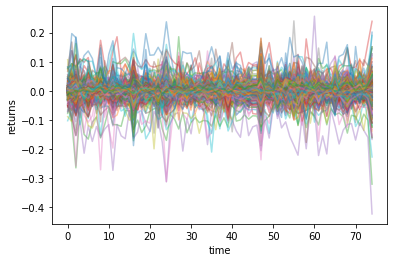

In [36]:
# (*) To communicate with Plotly's server, sign in with credentials file
import chart_studio.plotly as py 
from plotly.graph_objs import *

# (*) Useful Python/Plotly tools
import plotly.tools as tls   

# (*) Graph objects to piece together plots
from plotly.graph_objs import *
fig = plt.figure()
plt.plot(return_vec.T, alpha=.4);
plt.xlabel('time')
plt.ylabel('returns')
#py.iplot_mpl(fig, filename='s6_damped_oscillation')

In [37]:
FRED_Indicators = ['DTB4WK','DTB3','DTB6','DTB1YR']

import pandas_datareader.data as web

def Fred_Data(name):
    temp = web.DataReader(str(name), 'fred', start, end)
    temp.index = pd.to_datetime(temp.index)
    #temp = temp.resample(frequency).mean().dropna()
    return(temp)

FRED_set = []
FRED_completed = []
for i in FRED_Indicators:
    FRED_completed.append(i)
    FRED_set.append(Fred_Data(i))
                    
FRED_pvt = pd.DataFrame()

for x in range(0,len(FRED_completed)):
    values = FRED_set[x]
    #values.index = pd.to_datetime(FRED_set["DATE"])
    #values = values.resample(frequency).mean().dropna()
    #values['Symbol'] = x
    values = values.loc[~values.index.duplicated(keep='last')]
    #values = values.reset_index()

    FRED_pvt = pd.concat([FRED_pvt,values], axis=1)


In [38]:
#FRED_pvt[(FRED_pvt.index>='2021-01-01')&(FRED_pvt.index<'2021-02-01')].dropna()

In [39]:
TREASURY_BILL_RATE =  FRED_pvt['DTB1YR'].dropna().values[-1]
print(TREASURY_BILL_RATE)

0.04


In [40]:
#Genetic Algorithm

n_portfolio = 500

bestSharpe = 0
runs = 0
weight = None
bestMean = 0
bestStd = 0
means = np.array([])
stds = np.array([])
sharpes = np.array([])
bestWeights = None
weights = np.array([])

for _ in range(n_portfolio):    
    means1, stds1, sharpes1, weights1 = np.column_stack([
        random_portfolio((TREASURY_BILL_RATE*1/252.75), return_vec, True, bestWeights)        
        for _ in range(len(stocks.columns))
    ])
    means2, stds2, sharpes2, weights2 = np.column_stack([
        random_portfolio((TREASURY_BILL_RATE*1/252.75), return_vec, False)        
        for _ in range(len(stocks.columns))
    ])    
    means_ = np.append(means1,means2)
    stds_ = np.append(stds1,stds2)
    sharpes_ = np.append(sharpes1,sharpes2)
    weights_ = np.append(weights1,weights2)
    
    if(sharpes_.max()>bestSharpe):
        bestSharpe = sharpes_[sharpes_.argmax()]
        bestMean = means_[sharpes_.argmax()]
        bestStd = stds_[sharpes_.argmax()]
        #print(means_[sharpes_.argmax()])
        print(sharpes_[sharpes_.argmax()])
        #print(weights_[sharpes_.argmax()])
        bestWeights = weights_[sharpes_.argmax()]

    means = np.append(means,means_)
    stds = np.append(stds,stds_)
    sharpes = np.append(sharpes,sharpes_)
    weights = np.append(weights,weights_)
        

<ipython-input-17-63eb56444895>:39: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

/mnt/distvol/py39/lib/python3.9/site-packages/numpy/lib/shape_base.py:652: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



0.056092818425021666
0.06233620892591443


In [41]:
#optimal_risk_free_sharpe = optimize_sharpe_ratio(return_vec, 0)
#optimal_risk_free_sharpe = get_ret_vol_sr(np.array(fq.EfficientFrontier(pd.Series(np.mean((np.exp(return_vec)-1)*1,axis=1)),pd.DataFrame(np.cov((np.exp(return_vec)-1)*1)),risk_free_rate=0, freq=1, method='SLSQP').maximum_sharpe_ratio()['Allocation']),return_vec)


In [42]:
#returns, risks = optimal_portfolio(return_vec)

Weights
COF   0.981213
BF-B  0.962838
TSLA  0.948427
JNJ    0.93514
KO    0.895149
...        ...
CHTR   0.06266
AMT   0.051986
TCOM  0.051028
WU    0.045287
INTC  0.003012

[75 rows x 1 columns]

Optimal Genetic Algorithm Expected Annual Return: 0.27538992472776397
Optimal Genetic Algorithm Expected Annual Variance: 3.802042640360732
Optimal Genetic Algorithm sharpe ratio: 0.06233620892591443


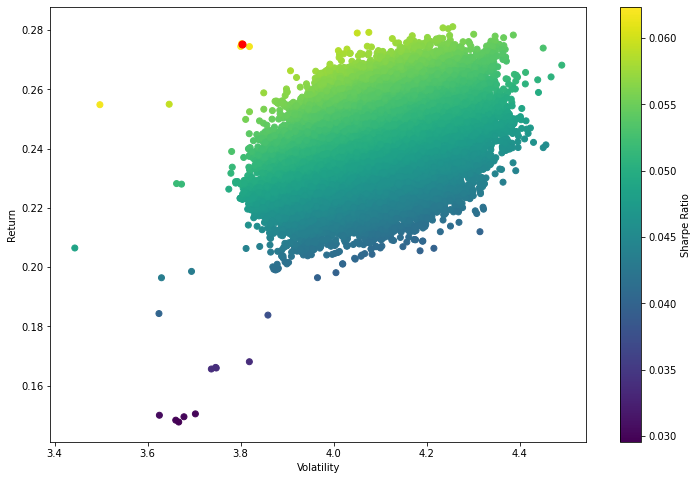

In [43]:

#print('Its location in the array: {}'.format(sharpes.argmax()))

df_ = pd.DataFrame(weights[sharpes.argmax()]).set_index(stocks.columns)
df_.columns = ['Weights']
df_.sort_values(by=['Weights'],ascending=False,inplace=True)
display(df_)
max_sr_ret = means[sharpes.argmax()]
max_sr_vol = stds[sharpes.argmax()]
max_sharpe = sharpes[sharpes.argmax()]

print('Optimal Genetic Algorithm Expected Annual Return: {}'.format((np.exp(max_sr_ret)-1)*252.75))
print('Optimal Genetic Algorithm Expected Annual Variance: {}'.format((np.exp(max_sr_vol)-1)*252.75))
print('Optimal Genetic Algorithm sharpe ratio: {}'.format(max_sharpe))

plt.figure(figsize=(12,8))
plt.scatter((np.exp(stds.astype(float))-1)*252.75, (np.exp(means.astype(float))-1)*252.75, c=sharpes, cmap='viridis')
plt.colorbar(label='Sharpe Ratio')
plt.xlabel('Volatility')
plt.ylabel('Return')

#plt.plot((np.exp(risks)-1)*252.75, (np.exp(returns)-1)*252.75, 'y-o')
plt.scatter((np.exp(max_sr_vol)-1)*252.75, (np.exp(max_sr_ret)-1)*252.75,c='red', s=50) # red dot
#plt.scatter((np.exp(bestStd)-1)*252.75,(np.exp(bestMean)-1)*252.75,c='purple', s=50) # red dot
#plt.scatter((np.exp(optimal_risk_free_sharpe[1])-1)*252.75, (np.exp(optimal_risk_free_sharpe[0])-1)*252.75,c='purple', s=50) # red dot
plt.show()

/mnt/distvol/py39/lib/python3.9/site-packages/numpy/core/_asarray.py:102: VisibleDeprecationWarning:

Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.



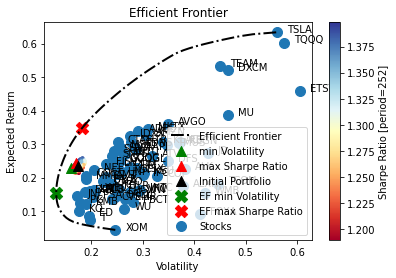

In [44]:
#import finquant.efficient_frontier as fq
#fq.EfficientFrontier(pd.Series(np.mean((np.exp(return_vec)-1)*252.75,axis=1)),pd.DataFrame(np.cov((np.exp(return_vec)-1)*252.75)),risk_free_rate=TREASURY_BILL_RATE, freq=252, method='SLSQP').maximum_sharpe_ratio().values

#pf = build_portfolio(data=stocks_df)

# performs and plots results of Monte Carlo run (5000 iterations)
opt_w, opt_res = pf.mc_optimisation(num_trials=500)
# plots the results of the Monte Carlo optimisation
pf.mc_plot_results()
# plots the Efficient Frontier
pf.ef_plot_efrontier()
# plots optimal portfolios based on Efficient Frontier
pf.ef.plot_optimal_portfolios()
# plots individual plots of the portfolio
pf.plot_stocks()

#get_ret_vol_sr(opt_w.loc['Max Sharpe Ratio'].values,return_vec)



In [45]:
display(pd.DataFrame(opt_w.loc['Max Sharpe Ratio']))

Max Sharpe Ratio
WU            0.012094
PBCT          0.008210
ALK           0.002950
DLR           0.026064
LH            0.012070
...                ...
CSX           0.007260
TMUS          0.003743
XEL           0.024007
ADBE          0.018387
TQQQ          0.004607

[75 rows x 1 columns]